# Waste Classification
The aim of this project is to classify wether trash is biodegradable or not, based on input images. 

## EDA
dataset : https://www.kaggle.com/datasets/aashidutt3/waste-segregation-image-dataset/data


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image, ImageFile
import random

import tensorflow as tf
from tensorflow import keras
import visualkeras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input


In [3]:
# counting the images in each subdirectory
subdirectory_path = "./Waste Segregation Image Dataset/test/wood_waste"

def count_images_in_subdirectory(subdirectory_path, extensions=('jpg', 'jpeg', 'png', 'bmp')):
    count = 0
    for root, _, files in os.walk(subdirectory_path):
        for file in files:
            if file.lower().endswith(extensions):
                count += 1
    return count

# Example usage
image_count = count_images_in_subdirectory(subdirectory_path)
print(f"Number of images in '{subdirectory_path}': {image_count}")


Number of images in './Waste Segregation Image Dataset/test/wood_waste': 59


Category: plastic_bags


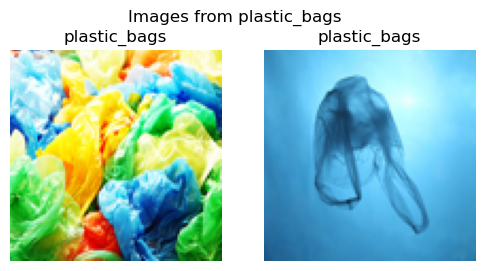

Category: paper_waste


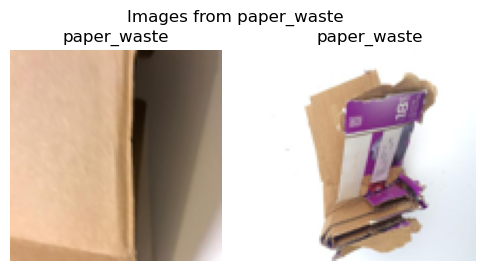

Category: plastic_bottles


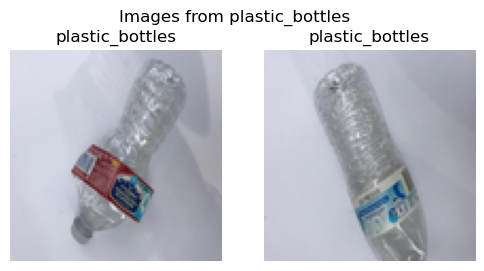

Category: leaf_waste


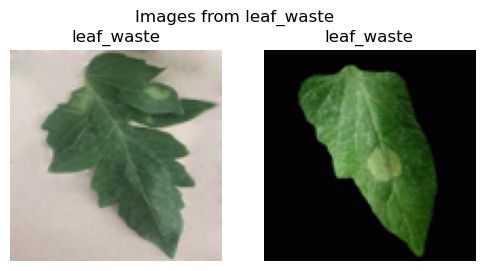

Category: food_waste


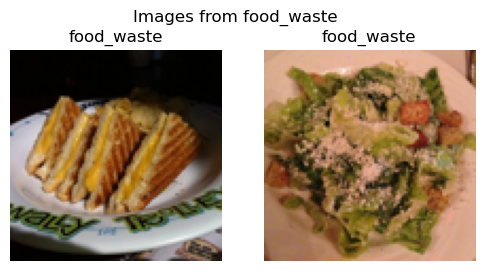

Category: ewaste


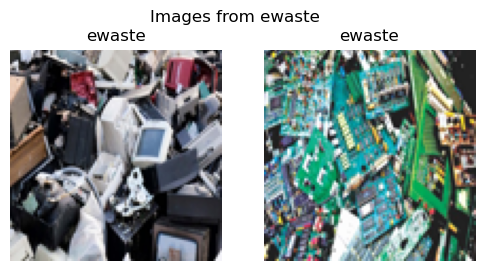

Category: .ipynb_checkpoints
No images found in category: .ipynb_checkpoints
Category: metal_cans


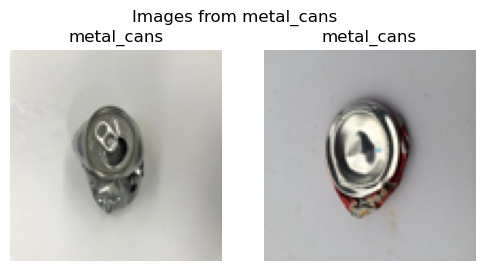

Category: wood_waste


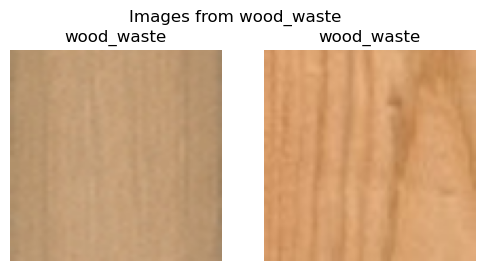

In [4]:


dataset_path = "./Waste Segregation Image Dataset/train"
image_size = (100, 100)
dimensions = []

# Function to plot random images from each subcategory
def plot_random_images(base_path, num_images=2):
    for category in os.listdir(base_path):  # biodegradable, non_biodegradable
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):  # Ensure it's a folder
            print(f"Category: {category}")
                    
            # Collect image file paths
            image_files = [
                os.path.join(category_path, file)
                for file in os.listdir(category_path)
                if file.lower().endswith(('png', 'jpg', 'jpeg'))
            ]
            
            if not image_files:
                print(f"No images found in category: {category}")
                continue  # Skip to the next category
            
            # Display a few random images
            random_images = random.sample(image_files, min(num_images, len(image_files)))
            fig, axes = plt.subplots(1, len(random_images), figsize=(len(random_images) * 3, 3))
            
            if len(random_images) == 1:
                axes = [axes]  # Ensure axes is iterable if there's only one image
            
            for img_path, ax in zip(random_images, axes):
                img = Image.open(img_path).resize(image_size)  # Resize image
                dimensions.append(img.size)
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(category)
            
            plt.suptitle(f"Images from {category}")
            plt.show()

# Call the function to display images
plot_random_images(dataset_path)


### Checking images dimensions

In [6]:
print("Unique Image Dimensions:", len(set(dimensions)))

Unique Image Dimensions: 1


### Class Balance

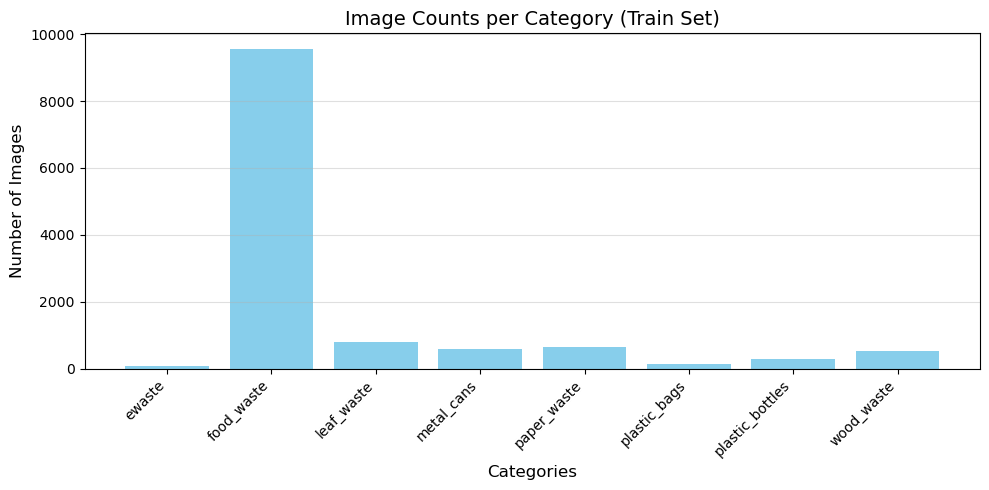

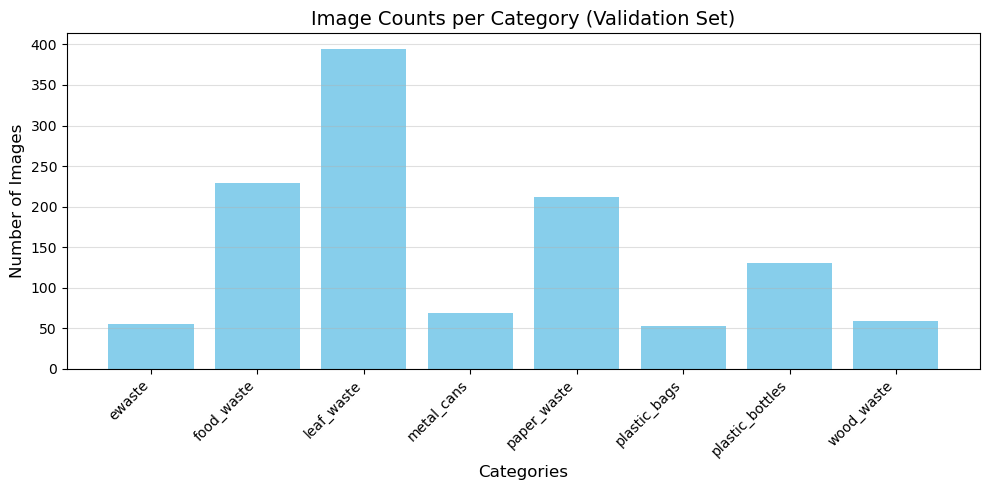

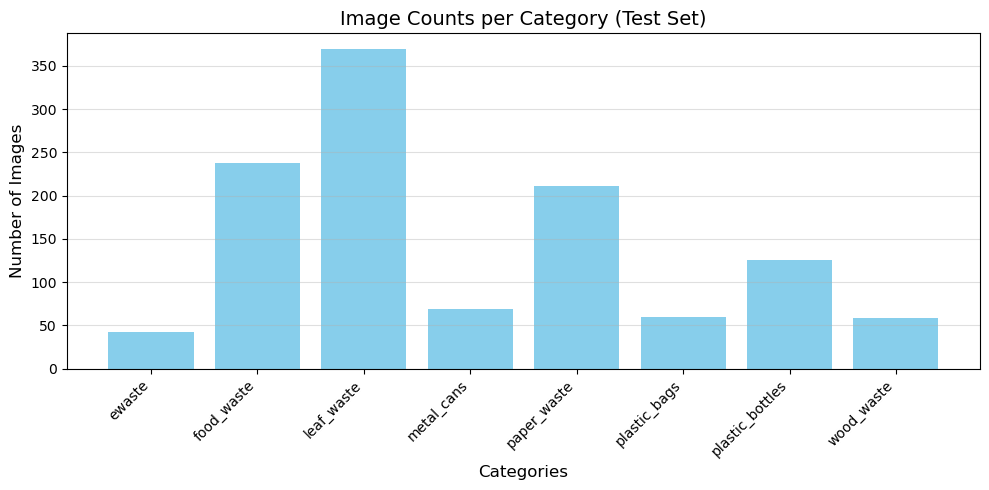

In [16]:
# Paths for datasets
train_path = "./Waste Segregation Image Dataset/train"
val_path = "./Waste Segregation Image Dataset/val"
test_path = "./Waste Segregation Image Dataset/test"

# Categories
categories = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"]

# Function to count images and plot
def plot_image_counts(dataset_path, title):
    class_counts = {}
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):  # Ensure it's a valid folder
            image_count = len([
                file for file in os.listdir(category_path)
                if file.lower().endswith(('png', 'jpg', 'jpeg'))
            ])
            class_counts[category] = image_count

    # Prepare data for visualization
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plot the counts
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Plot for train, validation, and test datasets
plot_image_counts(train_path, "Image Counts per Category (Train Set)")
plot_image_counts(val_path, "Image Counts per Category (Validation Set)")
plot_image_counts(test_path, "Image Counts per Category (Test Set)")


### Aspect Ratio Distribution

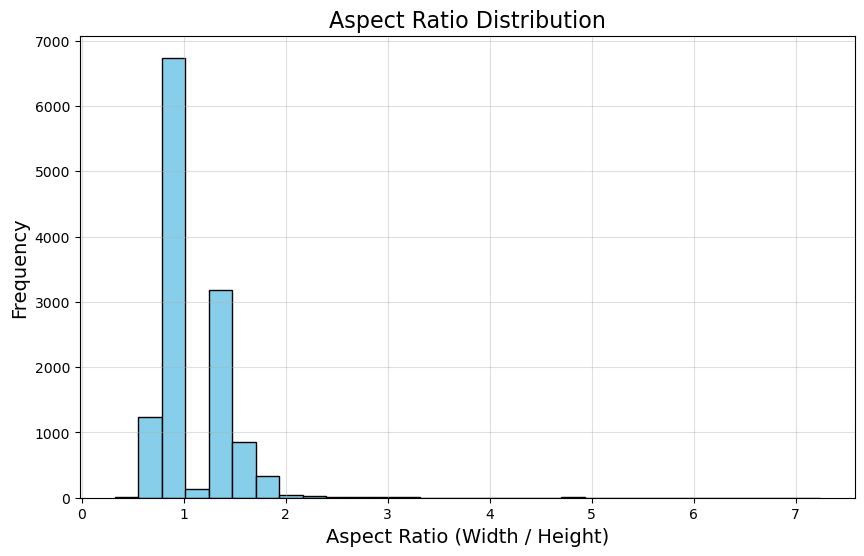

Number of Images: 12629
Mean Aspect Ratio: 1.13
Min Aspect Ratio: 0.33
Max Aspect Ratio: 7.24


In [8]:
# Function to calculate aspect ratios of images in a dataset
def analyze_aspect_ratios(base_path):
    aspect_ratios = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    aspect_ratios.append(width / height)
    
    return aspect_ratios

# Function to plot aspect ratio distribution
def plot_aspect_ratios(aspect_ratios):
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
    plt.title("Aspect Ratio Distribution", fontsize=16)
    plt.xlabel("Aspect Ratio (Width / Height)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(alpha=0.4)
    plt.show()


# Analyze and plot aspect ratios
aspect_ratios = analyze_aspect_ratios(dataset_path)
plot_aspect_ratios(aspect_ratios)

# Print summary statistics
print(f"Number of Images: {len(aspect_ratios)}")
print(f"Mean Aspect Ratio: {sum(aspect_ratios) / len(aspect_ratios):.2f}")
print(f"Min Aspect Ratio: {min(aspect_ratios):.2f}")
print(f"Max Aspect Ratio: {max(aspect_ratios):.2f}")


In [41]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Model Training

We will use xception, a pre-trained keras model , trained on the imageNet dataset

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/


XCeption is a model trained on the imagenet dataset with over 1000 classes.

In [5]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1738149428.413830   11384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Let's try one image

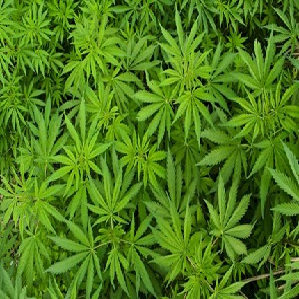

In [6]:
full_name='./Waste Segregation Image Dataset/train/leaf_waste/00000062.jpg'
img = load_img(full_name, target_size=(299, 299))
img

In [7]:
x = np.array(img)
x.shape

(299, 299, 3)

In [8]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [9]:
X.shape

(1, 299, 299, 3)

In [10]:
X = preprocess_input(X)

In [11]:
pred = model.predict(X)

I0000 00:00:1738149431.941399   11556 service.cc:148] XLA service 0x7fcb40036d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738149431.941443   11556 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-29 11:17:11.978478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738149432.308115   11556 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-29 11:17:13.491918: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1738149434.360458   11556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
decode_predictions(pred)

[[('n03991062', 'pot', np.float32(0.32059413)),
  ('n03457902', 'greenhouse', np.float32(0.19293582)),
  ('n11939491', 'daisy', np.float32(0.045149487)),
  ('n04589890', 'window_screen', np.float32(0.02809014)),
  ('n04209239', 'shower_curtain', np.float32(0.024374422))]]

These classes are not relevant for our specific use case. So we will remove the top layer and create a new one specific to out 8 classes. <br>
The process is called <b> transfer learning</b>, where we keep the convolutional layers of the Xception model, taht was trained on the ImageNet dataset, but we remove the top (the dense layer) and create a new one that learns our classes and makes predictions based on them.


## Transfer learning

* Reading data with `ImageDataGenerator`
* Train `Xception` on smaller images (150x150)


In [22]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "./Waste Segregation Image Dataset/train",
    target_size=(150, 150),
    batch_size=32,
    classes=categories
)

Found 12629 images belonging to 8 classes.


Experiment with 150 x150 images first because it takes 75% less time to train that using 299x 299 images

In [23]:
train_ds.class_indices

{'ewaste': 0,
 'food_waste': 1,
 'leaf_waste': 2,
 'metal_cans': 3,
 'paper_waste': 4,
 'plastic_bags': 5,
 'plastic_bottles': 6,
 'wood_waste': 7}

It's similar to one-hot encoding.

In [24]:
X, y = next(train_ds)

X: images, y:labels

In [25]:
print ("Batch shape:", X.shape)

Batch shape: (32, 150, 150, 3)


32 images, each having 150 width and 150 height, with 3 channels (R,G,B)

In [26]:
y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

1st is wood_waste, because there's 1 in the 8th  position, corresponding to the 8th class, and so on

### Visualizing XCeption

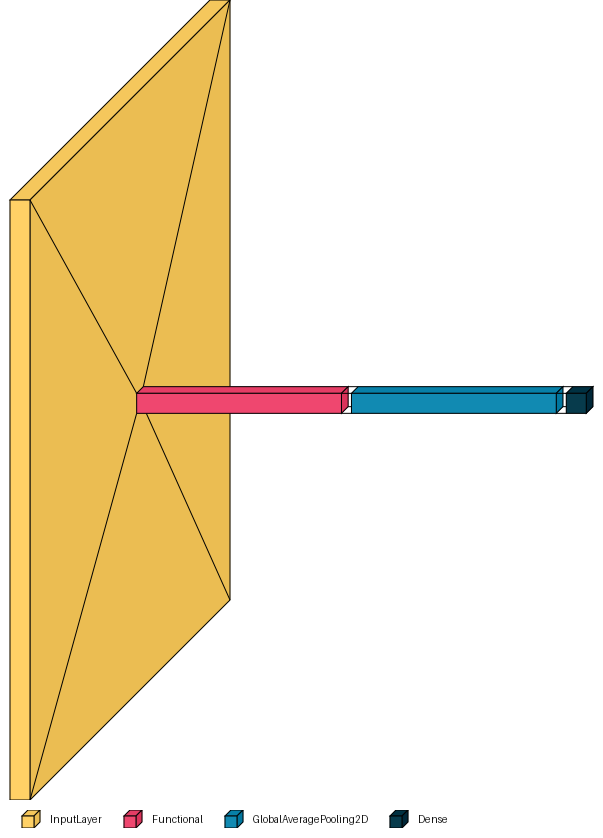

In [27]:
#visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

#### Create a validation dataset

In [28]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    "./Waste Segregation Image Dataset/val",
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,
    classes=categories

)

Found 1201 images belonging to 8 classes.


In [29]:
# Build base model
base_model = Xception(weights='imagenet',
                      include_top=False, # to remove the dense layer, keeping the convolutional layers
                      input_shape=(150,150,3))

# Prevents changing the convolutional base (by preventing the weights being updated during training)
base_model.trainable = False


## Approach: 

    Stage 1: Classify the waste into one of the 8 subcategories (leaf_waste, food_waste, plastic_bag, etc.).
    Stage 2: Use the output from Stage 1 to determine whether the waste is biodegradable or non-biodegradable.

In [30]:
subcategory_to_biodegradable = {
    "food": "biodegradable",
    "leaf": "biodegradable",
    "paper": "biodegradable",
    "wood": "biodegradable",
    "e-waste": "non_biodegradable",
    "metal": "non_biodegradable",
    "plastic_bags": "non_biodegradable",
    "plastic_bottles": "non_biodegradable",
}


#### Create a new top

We are not keeping the dense layer(predicting 1000 classes) because we will create a custom one (with our 8 classes).

Adding a Custom Classification Head: For hierarchical classification problem:

    Use a dense layer for the 8 subcategories.
    Add another dense layer for biodegradability.

    

In [31]:
# Define expected image shape as input
inputs = Input(shape=(150,150,3))

# Use the base model to extract the vector representations
base = base_model(inputs, training=False) 

# Convert matrices into vectors using pooling layer
vectors = GlobalAveragePooling2D()(base)

# Create dense layer of 8 classes
subcategory_output = Dense(8, name='subcategory')(vectors)
#biodegradability_output = Dense(1, activation='sigmoid', name='biodegradability')(vectors)

# Full model
model = Model(inputs, subcategory_output)



### Compiling the model
Use a different loss function for each output.<br>
    * subcategory : 8 classes, so we use sparse categorical cross entropy
    * category : 2 classes, so we use binary cross entropy




In [21]:
for x_batch, y_batch in train_ds:
    print(f"X batch shape: {x_batch.shape}, Y batch shape: {y_batch.shape}")
    break  # Check the first batch

NameError: name 'train_ds' is not defined

In [29]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']    

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=metrics)



In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subcategory (Dense)             │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,877,872 (79.64 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                    batch_size=32
                   )


Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 99/395 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.8576 - loss: 0.7385

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


395/395 ━━━━━━━━━━━━━━━━━━━━ 55s 118ms/step - accuracy: 0.9213 - loss: 0.4183 - val_accuracy: 0.8826 - val_loss: 1.0140
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.9743 - loss: 0.1461 - val_accuracy: 0.8551 - val_loss: 1.4331
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9866 - loss: 0.0619 - val_accuracy: 0.8734 - val_loss: 1.4158
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9873 - loss: 0.0667 - val_accuracy: 0.8518 - val_loss: 1.8098
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9947 - loss: 0.0239 - val_accuracy: 0.8684 - val_loss: 1.7204
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9947 - loss: 0.0290 - val_accuracy: 0.8801 - val_loss: 1.8101
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.9920 - loss: 0.0546 - val_accuracy: 0.8826 - val_loss: 1.9083
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9923 - loss: 0.0492 - val_accura

Model might be overfitting. Training accuracy is 99%, but validation accuracy is around 87%

In [32]:
np.array(history.history['accuracy']).round(4)

array([0.9522, 0.9747, 0.9846, 0.9876, 0.9941, 0.9918, 0.99  , 0.9923,
       0.9945, 0.9982])

In [33]:
np.array(history.history['val_accuracy']).round(4)

array([0.8826, 0.8551, 0.8734, 0.8518, 0.8684, 0.8801, 0.8826, 0.8268,
       0.8743, 0.8651])

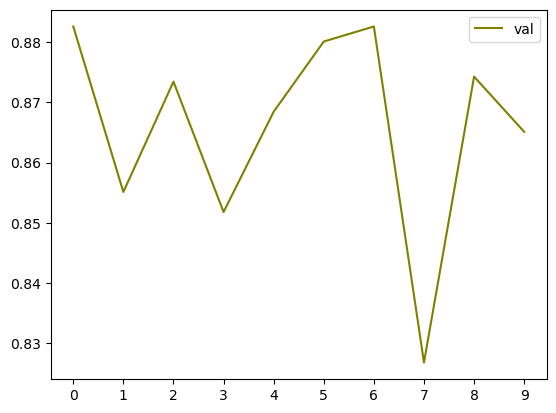

In [34]:
#plt.plot(history.history['accuracy'], label='train', color='skyblue')
plt.plot(history.history['val_accuracy'], label='val', color='olive')
plt.xticks(np.arange(10))
plt.legend()

Not very good

### Adjusting the learning rate


In [35]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = GlobalAveragePooling2D()(base)
    outputs = Dense(8)(vectors)
    model = Model(inputs, outputs)
    
    #########################################

   
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model

In [36]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, validation_data=val_ds, epochs=10)
    
    scores[lr]= history.history
    print("\n\n")
    

0.0001
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - accuracy: 0.6474 - loss: 1.0968 - val_accuracy: 0.6736 - val_loss: 0.9656
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9339 - loss: 0.2595 - val_accuracy: 0.7960 - val_loss: 0.6453
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9563 - loss: 0.1679 - val_accuracy: 0.8226 - val_loss: 0.5612
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9635 - loss: 0.1328 - val_accuracy: 0.8393 - val_loss: 0.5037
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9713 - loss: 0.1072 - val_accuracy: 0.8510 - val_loss: 0.4705
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.9747 - loss: 0.0954 - val_accuracy: 0.8568 - val_loss: 0.4616
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9793 - loss: 0.0818 - val_accuracy: 0.8601 - val_loss: 0.4459
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.9801 - loss: 0

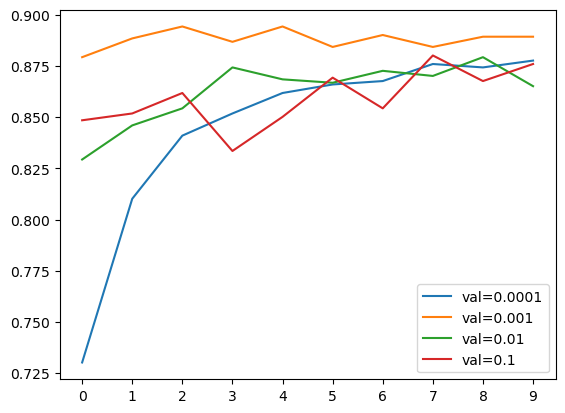

In [48]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' %lr))

plt.xticks(np.arange(10))
plt.legend()

In [49]:
learning_rate = 0.001 
# best

## Checkpoiting
Only saving models when they are better than previous models.  We train with callbacks and use ModelCheckpoint from keras.callbacks

In [50]:
model.save_weights('model_v1.weights.h5')  # Save weights in .weights.h5 format


In [51]:
checkpoint= keras.callbacks.ModelCheckpoint( 'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras', 
                                            save_best_only=True,
                                            monitor='val_accuracy',
                                            mode='max')





In [52]:
keras.callbacks.ModelCheckpoint?

Init signature:
keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None,
)
Docstring:     
Callback to save the Keras model or model weights at some frequency.

`ModelCheckpoint` callback is used in conjunction with training using
`model.fit()` to save a model or weights (in a checkpoint file) at some
interval, so the model or weights can be loaded later to continue the
training from the state saved.

A few options this callback provides include:

- Whether to only keep the model that has achieved the "best performance" so
  far, or whether to save the model at the end of every epoch regardless of
  performance.
- Definition of "best"; which quantity to monitor and whether it should be
  maximized or minimized.
- The frequency it should save at. Currently, the callback supports saving
  at the end of every epoch, or after a fixed 

In [53]:
learning_rate=0.001

model = make_model(learning_rate=learning_rate)

history= model.fit( train_ds,
                   epochs=10,
                   callbacks=[checkpoint],
                   batch_size=32,
                   validation_data=val_ds
                  )



Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.8894 - loss: 0.3740 - val_accuracy: 0.8601 - val_loss: 0.4776
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9806 - loss: 0.0709 - val_accuracy: 0.8818 - val_loss: 0.4562
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9888 - loss: 0.0442 - val_accuracy: 0.8859 - val_loss: 0.4290
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9939 - loss: 0.0289 - val_accuracy: 0.8951 - val_loss: 0.4022
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9955 - loss: 0.0235 - val_accuracy: 0.8868 - val_loss: 0.4321
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9983 - loss: 0.0147 - val_accuracy: 0.8918 - val_loss: 0.4534
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9995 - loss: 0.0106 - val_accuracy: 0.8868 - val_loss: 0.4776
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9996 - loss: 0.0082 -

We can see that the best performing model is xception_v1_04_0.895.keras, with a val_accuracy: 0.8995. It is now saved in the directory

## Adding more layers
The role of the inner layer is to do some intermediate processing of the vector reporesentation, before it goes to the output.
<br> This makes the neural network more powerful, by learning internal representations, helpful to differentiate between classes.
<br> We will test adding more layers and see if the model improves. If it doesn't, we won't use those layers

In [37]:
def make_model(learning_rate=0.001, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = GlobalAveragePooling2D()(base)
    inner = Dense(size_inner, activation='relu')(vectors)
    outputs = Dense(8)(inner)
    model = Model(inputs, outputs)
    
    #########################################

   
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model

In [38]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,910,658 (79.77 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 32,786 (128.07 KB)

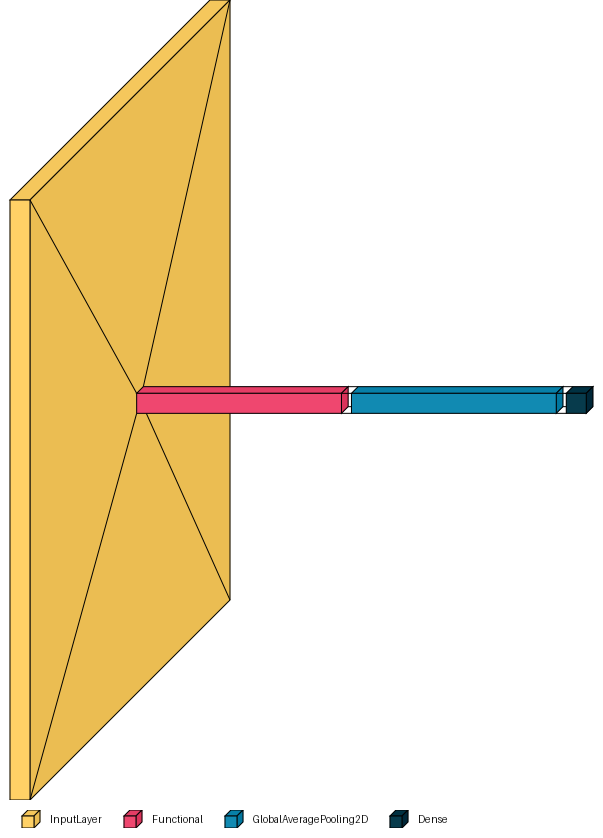

In [39]:
visualkeras.layered_view(model,legend=True)

#### Tuning the size_inner parameter for the inner Dense layer

In [40]:
learning_rate=0.001
scores = {}

for size in [10 ,100, 500]:
    print(size)
    model= make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, validation_data=val_ds, epochs=10)
    scores[size]=history.history

    print("\n\n")

10
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.8584 - loss: 0.4747 - val_accuracy: 0.8451 - val_loss: 0.6263
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9712 - loss: 0.0996 - val_accuracy: 0.8551 - val_loss: 0.5851
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9818 - loss: 0.0654 - val_accuracy: 0.8743 - val_loss: 0.5433
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9891 - loss: 0.0465 - val_accuracy: 0.8751 - val_loss: 0.5459
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9922 - loss: 0.0327 - val_accuracy: 0.8643 - val_loss: 0.5749
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9953 - loss: 0.0267 - val_accuracy: 0.8759 - val_loss: 0.5668
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9973 - loss: 0.0187 - val_accuracy: 0.8684 - val_loss: 0.5962
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.9977 - loss: 0.014

([<matplotlib.axis.XTick at 0x7f5ed0a82a80>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

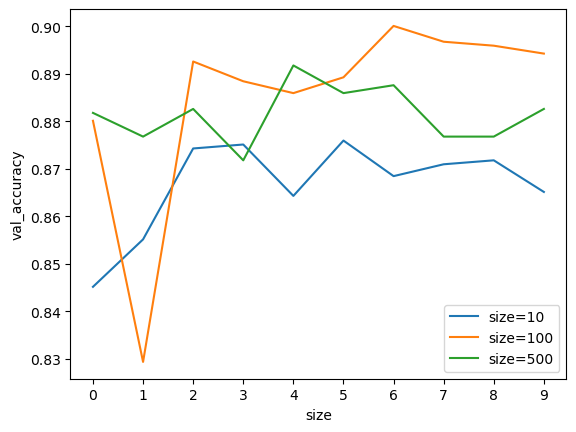

In [45]:
for size,hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('size=%s' %size))
plt.legend()
plt.xlabel('size')
plt.ylabel('val_accuracy')
plt.xticks(np.arange(10))
# plt.xlim(0.86,0.89)

#plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])

### !!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
size_inner=100 # best

inner_size = 100 seems like the best model, but i will use checkpointing to get the best model.
our accuracy without the inner layer was 0.893. with the inner layer, and after finetuning, the best we could reach is at epoch=6 for the model with inner_size= 150, and it has val_accuracy: 0.9017 


In [ ]:
checkpoint= keras.callbacks.ModelCheckpoint( 'xception_v2_{epoch:02d}_{val_accuracy:.3f}.keras', 
                                            save_best_only=True,
                                            monitor='val_accuracy',
                                            mode='max')


In [ ]:
learning_rate=0.001
size_inner=150

model = make_model(learning_rate=learning_rate, size_inner=size_inner)

history= model.fit( train_ds,
                   epochs=10,
                   callbacks=[checkpoint],
                   batch_size=32,
                   validation_data=val_ds
                  )



Model is overfitting. Let's not use inner layers

## Regularization and dropout
This method means hiding some parts of the input before the next layer of the Neural Network sees it. <br>
We freeze some neuroms so they dont get the output from previous layers, and their weights don't get updated.<br>
<b>Dropout</b> is randomly freezing some parts of the input.<br>
We will add a dropout layer between the inner layer and the outputs layer, to <b>regularize</b> the inner dense layer's outputs.<br>
We will experiment with different value for droprate and see how the model will learn and if the accuracy will improve(after training it for more epochs to give the model chance to learn, considering that part of the input is hidden)

In [17]:
def make_model(learning_rate=0.001, droprate=0.5, size_inner=150):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = GlobalAveragePooling2D()(base)
    inner = Dense(size_inner, activation='relu')(vectors)
    drop = Dropout(droprate)(inner)
    outputs = Dense(8)(drop)
    model = Model(inputs, outputs)
    
    #########################################

   
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model



In [18]:
scores = {}
for rate in [0.0, 0.25, 0.4, 0.55, 0.65]:
    print(rate)
    model= make_model(learning_rate=0.001,droprate=rate)
    history=  model.fit(train_ds, validation_data=val_ds, epochs=20)
    scores[rate] = history.history

    print("\n\n")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2182431413.py, line 4)

In [ ]:
visualkeras.layered_view(model,legend=True)


In [ ]:
for rate,hist in scores.items():
    #if rate not in [0.55, 0.65]:
    plt.plot(hist['val_accuracy'], label=('droprate=%s' %rate))

plt.ylim(0.86, 0.90)
plt.legend()
plt.xlabel('droprate')
plt.ylabel('val_accuracy')


In [ ]:
drop=0.0 #best

## Data Augmentation
Creating more data from existing data, by applying augmentations to the images, such as:

    - flip (horizontally or vertically)
    - rotate (by an angle, clockwise or counter-clockwise)
    - shift (by height or width)
    - shear (extend from one corner)
    - zoom (in/out, horizontally/vertically)
    - brightness/contast : + or -
    - ...

To add augmentations, we will use <b> parameters</b> in the <b>ImageDataGenerator</b> function.<br>
#### NOTE
we only apply augmentations to the training subset. NEVER to the testing or validation subsets.

In [9]:
train_gen_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=8.0,
                                   height_shift_range=8.0,
                                   vertical_flip=True,
                                   shear_range=8.0,
                                   zoom_range=0.2,
                                  )


train_ds_aug = train_gen_aug.flow_from_directory(
    './Waste Segregation Image Dataset/train',
    target_size=(150, 150),
    batch_size=32,
    classes=categories
    
)



Found 12629 images belonging to 8 classes.


In [11]:
checkpoint_aug = keras.callbacks.ModelCheckpoint(
    'xception_aug_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [28]:
learning_rate = 0.001
droprate = 0.0
inner_size=150

model = make_model(
    learning_rate=learning_rate,
    size_inner=inner_size,
    droprate=droprate
)

history = model.fit(train_ds_aug, epochs=25, validation_data=val_ds,
                   callbacks=[checkpoint_aug])

Epoch 1/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 255ms/step - accuracy: 0.9057 - loss: 0.3282 - val_accuracy: 0.8510 - val_loss: 0.5130
Epoch 2/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 92s 232ms/step - accuracy: 0.9603 - loss: 0.1181 - val_accuracy: 0.8743 - val_loss: 0.4665
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.9686 - loss: 0.1010 - val_accuracy: 0.8668 - val_loss: 0.5252
Epoch 4/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 231ms/step - accuracy: 0.9738 - loss: 0.0779 - val_accuracy: 0.8601 - val_loss: 0.5328
Epoch 6/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 92s 232ms/step - accuracy: 0.9761 - loss: 0.0725 - val_accuracy: 0.8701 - val_loss: 0.4578
Epoch 7/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 231ms/step - accuracy: 0.9776 - loss: 0.0669 - val_accuracy: 0.8609 - val_loss: 0.5640
Epoch 8/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 93s 234ms/step - accuracy: 0.9788 - loss: 0.0669 - val_accuracy: 0.8768 - val_loss: 0.4530
Epoch 9/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.9781 - loss: 

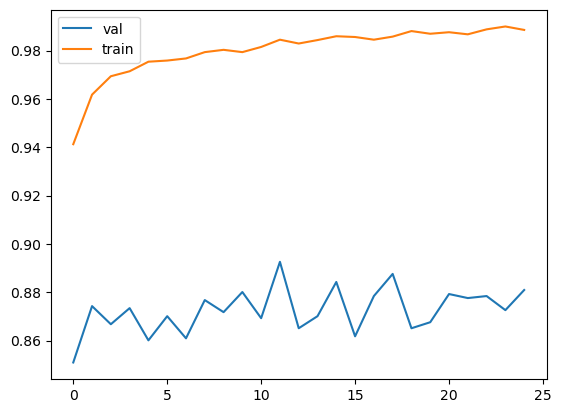

In [29]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

Data Augmentation didn't do any significant improvement so i won't use it

## Training a larger model
We have trained a model with 150x150 images. Now let's train it with 299x299 images

In [34]:
def make_model(input_size=299, learning_rate=0.01, size_inner=100):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = GlobalAveragePooling2D()(base)
    
    inner = Dense(size_inner, activation='relu')(vectors)    
    outputs = Dense(8)(inner)
    
    model = Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [35]:
input_size = 299

In [36]:
train_gen=ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

train_ds = train_gen.flow_from_directory(
    './Waste Segregation Image Dataset/train',
    target_size=(input_size, input_size),
    batch_size=32,
    classes=categories
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './Waste Segregation Image Dataset/val',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False,
    classes=categories
)

Found 12629 images belonging to 8 classes.
Found 1201 images belonging to 8 classes.


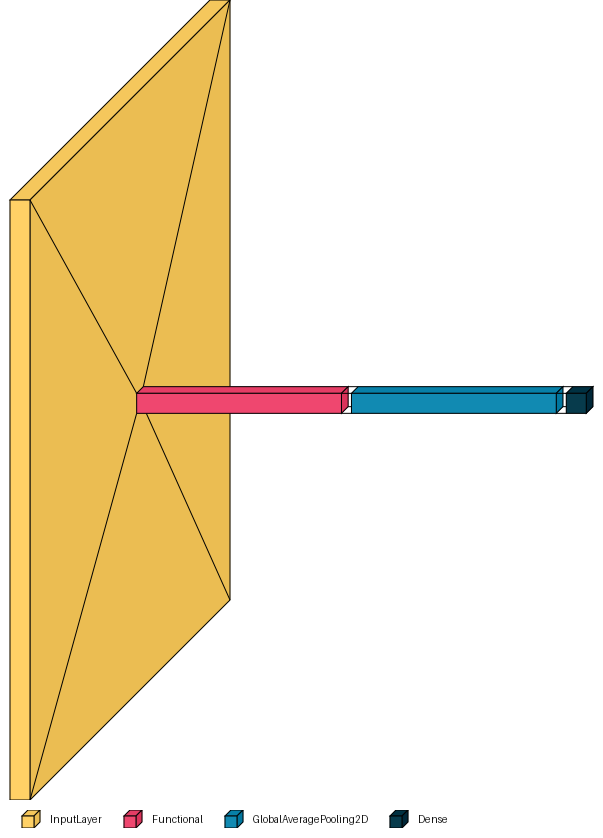

In [37]:
visualkeras.layered_view(model,legend=True)

In [38]:
checkpoint_299 = keras.callbacks.ModelCheckpoint(
    'xception_299_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [42]:
learning_rate = 0.001
size = 150

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
)

history = model.fit(train_ds, epochs=30, validation_data=val_ds,
                   callbacks=[checkpoint_299])

Epoch 1/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9369 - loss: 0.2172

2025-01-29 11:30:55.303681: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


395/395 ━━━━━━━━━━━━━━━━━━━━ 108s 259ms/step - accuracy: 0.9370 - loss: 0.2169 - val_accuracy: 0.9309 - val_loss: 0.2715
Epoch 2/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step - accuracy: 0.9921 - loss: 0.0253 - val_accuracy: 0.9067 - val_loss: 0.4180
Epoch 3/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.9970 - loss: 0.0122 - val_accuracy: 0.9234 - val_loss: 0.3393
Epoch 4/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 231ms/step - accuracy: 0.9988 - loss: 0.0063 - val_accuracy: 0.9342 - val_loss: 0.3535
Epoch 5/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.9301 - val_loss: 0.3816
Epoch 6/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9292 - val_loss: 0.3917
Epoch 7/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9301 - val_loss: 0.4460
Epoch 8/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.9986 - loss: 0.0037 - va

# Load the model
Restart the kernel, load the best saved model, test it

In [8]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './Waste Segregation Image Dataset/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 1206 images belonging to 8 classes.


In [6]:
model = keras.models.load_model('xception_299_04_0.934.keras')

In [7]:
model.evaluate(test_ds)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 613s 16s/step - accuracy: 0.9330 - loss: 0.2239


[0.2804110646247864, 0.9286898970603943]

In [9]:
path = "./Waste Segregation Image Dataset/test/metal_cans/metal47.jpg"

In [10]:
img = load_img(path, target_size=(299,299))

In [13]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [14]:
X = preprocess_input(X)

In [15]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [16]:
pred[0]

array([-2.7836747 , -0.60133016, -2.0645955 ,  8.189927  , -0.6107491 ,
       -3.4859295 ,  0.6139733 , -3.221171  ], dtype=float32)

In [17]:
categories = ["ewaste", 
              "food_waste", 
              "leaf_waste",
              "metal_cans",
              "paper_waste", 
              "plastic_bags",
              "plastic_bottles",
              "wood_waste"]


In [18]:
dict(zip(categories, pred[0]))

{'ewaste': -2.7836747,
 'food_waste': -0.60133016,
 'leaf_waste': -2.0645955,
 'metal_cans': 8.189927,
 'paper_waste': -0.6107491,
 'plastic_bags': -3.4859295,
 'plastic_bottles': 0.6139733,
 'wood_waste': -3.221171}

the highest score is for the metal cans

In [23]:
subcategory_to_biodegradable = {
    0: 'non_biodegradable',  
    1: 'biodegradable',
    2: 'biodegradable',
    3: 'non_biodegradable',
    4: 'biodegradable',
    5: 'non_biodegradable',
    6: 'non_biodegradable',
    7: 'biodegradable'
}



In [24]:
def get_biodegradability(pred_index):
    return subcategory_to_biodegradable[pred_index]


In [26]:
predicted_index = np.argmax(pred[0])  # Get the index of the highest probability
biodegradability = get_biodegradability(predicted_index)
print(f"Predicted Category: {categories[predicted_index]}")
print(f"Biodegradability: {biodegradability}")



Predicted Category: metal_cans
Biodegradability: non_biodegradable


In [52]:
def make_prediction(path):
    img = load_img(path, target_size=(299,299))
    x = np.array(img)
    X =preprocess_input(np.array([x]))
    pred = model.predict(X)
    predicted_index = np.argmax(pred[0])
    biodegradability = get_biodegradability(predicted_index)
    confidence_scores = dict(zip(categories, pred[0].tolist()))
    
    final_pred = {'Predicted Category' : categories[predicted_index],
                   'Biodegradability' : biodegradability,
                    'Confidence_score' : confidence_scores
                    }
    return final_pred

    
    

In [53]:
make_prediction(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


{'Predicted Category': 'metal_cans',
 'Biodegradability': 'non_biodegradable',
 'Confidence_score': {'ewaste': -2.783674716949463,
  'food_waste': -0.6013301610946655,
  'leaf_waste': -2.0645954608917236,
  'metal_cans': 8.189927101135254,
  'paper_waste': -0.6107491254806519,
  'plastic_bags': -3.485929489135742,
  'plastic_bottles': 0.6139733195304871,
  'wood_waste': -3.2211709022521973}}

In [38]:
!jupyter nbconvert --to python notebook-Xception-final.ipynb

[NbConvertApp] Converting notebook notebook-Xception-final.ipynb to python
[NbConvertApp] Writing 25306 bytes to notebook-Xception-final.py
